In [2]:
import cudf
import cuml
from datetime import datetime
import requests
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
import cupy as cp
from cuml.tsa.arima import ARIMA
import pandas as pd
from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from pmdarima.datasets import load_wineind
from cuml import ExponentialSmoothing

# Time Series forecasting
We are going to use the population_estimate dataframe for this lesson


In [3]:
pop = cudf.read_csv("population_estimate.csv")
pop.Year = cudf.to_datetime(pop.Year, format='%Y')
pop.shape
pop

,Year,Male,Female
0,1875-01-01,238.1,183.2
1,1876-01-01,250.4,194.2
2,1877-01-01,252.5,201.6
3,1878-01-01,264.6,211.5
4,1879-01-01,281.8,225.5
...,...,...,...
132,2007-01-01,2083.4,2169.2
133,2008-01-01,2104.1,2187.4
134,2009-01-01,2134.0,2213.2
135,2010-01-01,2158.2,2234.9


Text(0.5, 1.0, 'Population growth for men between 1875 and 2011, measured on a yearly cadence')

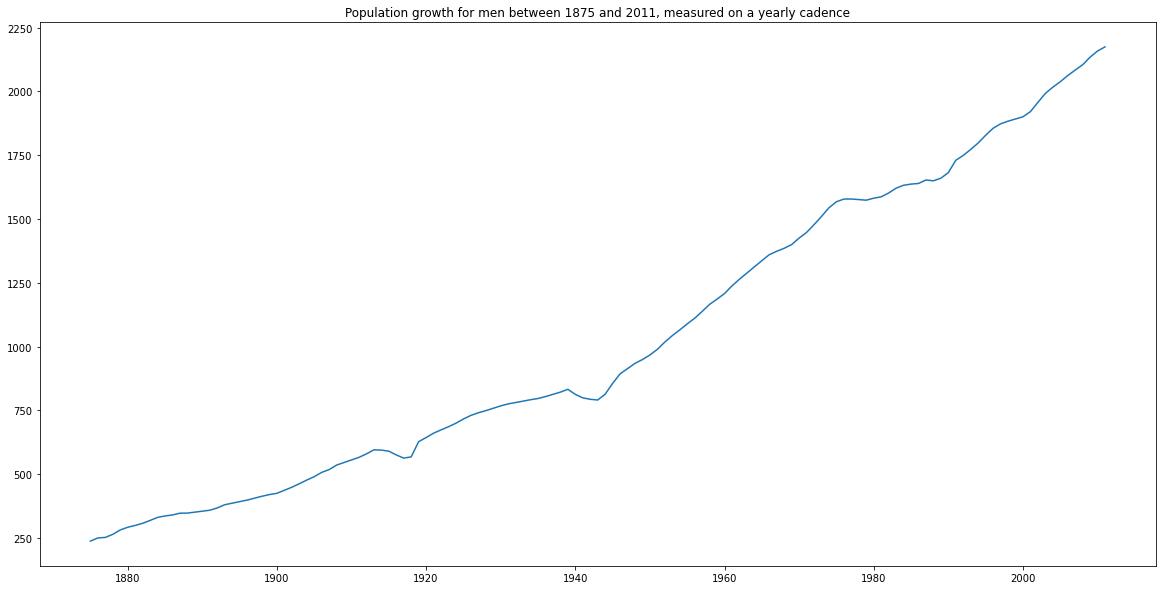

In [3]:
# Quick visualization
# pretty clear its trending up, but has no seasonality
fig, ax = plt.subplots(figsize = (20,10))

x = pop['Year'].to_pandas()
y = pop['Male'].to_pandas()
plt.plot(x,y)
ax.set_title('Population growth for men between 1875 and 2011, measured on a yearly cadence')

In [4]:
# Test for stationarity

result = adfuller(pop['Male'].to_pandas())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.022094
p-value: 0.998701
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


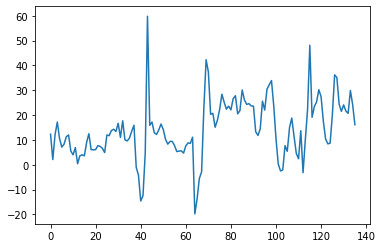

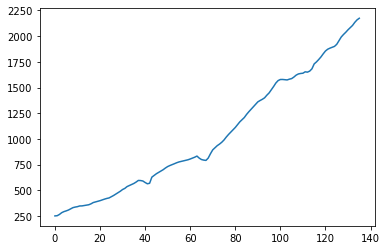

In [6]:
from math import sin
from math import radians
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
 
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
 
data = pop['Male']
# difference the dataset
diff = difference(pop['Male'].to_pandas(), 1)
pyplot.plot(diff)
pyplot.show()
# invert the difference
inverted = [inverse_difference(data[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

Text(0.5, 1.0, 'Population growth for men between 1875 and 2011, measured on a yearly cadence')

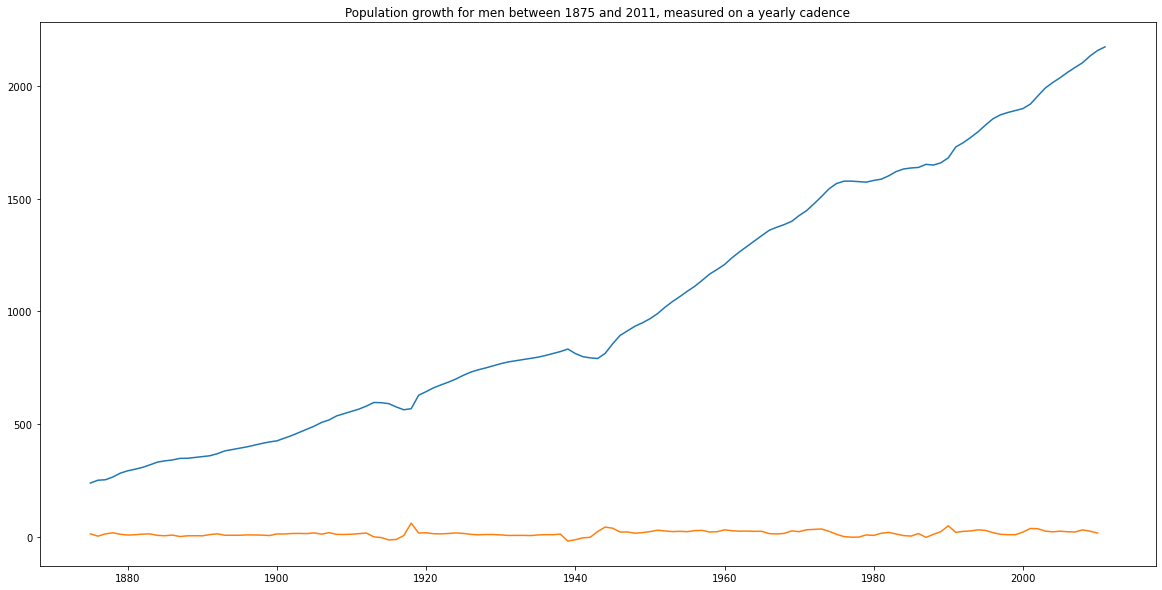

In [7]:
# looks like we need to difference this to get rid of the effect 

fig, ax = plt.subplots(figsize = (20,10))

x = pop['Year'].to_pandas()
x2 = pop['Year'].to_pandas()[:-1]
y = pop['Male'].to_pandas()
y2 = diff
plt.plot(x,y)
plt.plot(x2,y2)
ax.set_title('Population growth for men between 1875 and 2011, measured on a yearly cadence')

In [10]:
# Test for stationarity
# p <.05 
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.373174
p-value: 0.000004
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


In [11]:
%%time

# Fit an ARIMA(1,2,1) model
model_pop = ARIMA(pd.Series(diff), (1,2,1), fit_intercept=True)
model_pop.fit()

# Predict in-sample and forecast out-of-sample
pred_pop = model_pop.predict(0, 136).flatten()
forec = model_pop.forecast(45)

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Pass order=(1, 2, 1) as keyword args. From version 21.06, passing these as positional arguments will result in an error
  


[W] [18:02:50.331429] WARNING(`predict`): predictions before 2 are undefined, will be set to NaN
CPU times: user 450 ms, sys: 176 ms, total: 627 ms
Wall time: 627 ms


In [12]:
pred_pop[0] = 0
pred_pop[1] = 0

invert_pred = [inverse_difference(pop['Male'][i], diff[i]) for i in range(len(diff))]
df = cudf.DataFrame(columns = ['actual', 'yhat'])
df['yhat'] = invert_pred
df['actual'] = pop['Male']

In [13]:
forec = forec.flatten()
forec_ran = range(135, 180)

The RMSE is 18.45152233477195


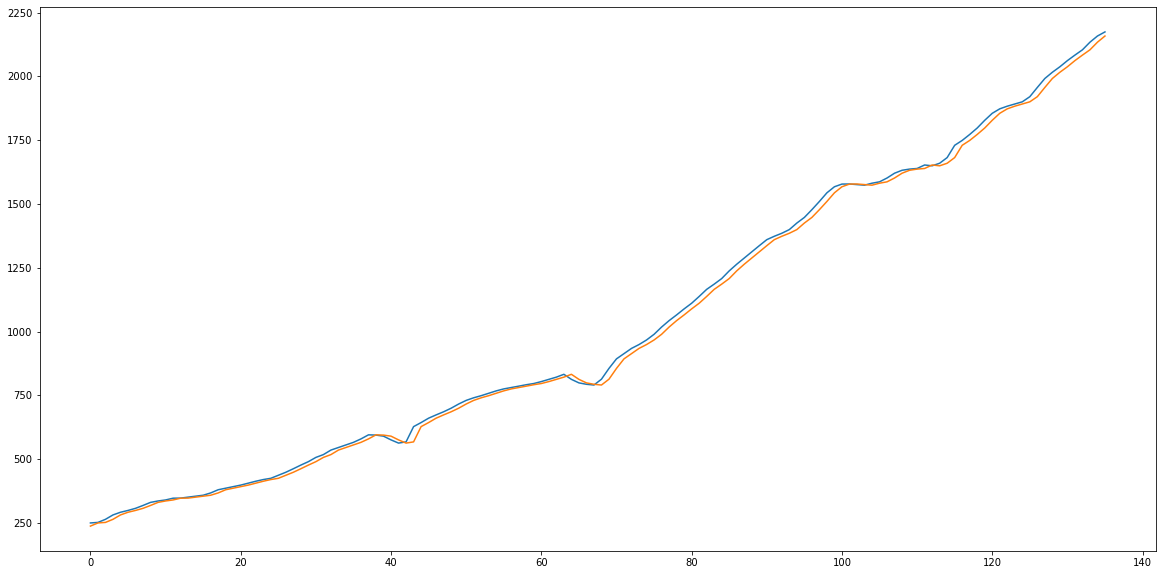

In [66]:
rmse = cuml.metrics.regression.mean_squared_error(y_pred = df['yhat'], y_true = df['actual'], squared = False)
print(f'The RMSE is {rmse}')
fig,ax = plt.subplots(figsize = (20,10))

plt.plot(df.index.to_pandas(), df['yhat'].to_pandas())
plt.plot(df.index.to_pandas(), df['actual'].to_pandas())


# AutoArima with cuML
 cuML has its own built in AutoArima functionality. the algorithm is capable inferring 
 the p,d, and q values 

In [15]:
from cuml.tsa.auto_arima import AutoARIMA

# this is a dataset from R
wineind = load_wineind().astype(np.float64)
# training and test sets
train = wineind[:132]
test = wineind[132:]



array([15136., 16733., 20016., 17708., 18019., 19227., 22893., 23739.,
       21133., 22591., 26786., 29740., 15028., 17977., 20008., 21354.,
       19498., 22125., 25817., 28779., 20960., 22254., 27392., 29945.,
       16933., 17892., 20533., 23569., 22417., 22084., 26580., 27454.,
       24081., 23451., 28991., 31386., 16896., 20045., 23471., 21747.,
       25621., 23859., 25500., 30998., 24475., 23145., 29701., 34365.,
       17556., 22077., 25702., 22214., 26886., 23191., 27831., 35406.,
       23195., 25110., 30009., 36242., 18450., 21845., 26488., 22394.,
       28057., 25451., 24872., 33424., 24052., 28449., 33533., 37351.,
       19969., 21701., 26249., 24493., 24603., 26485., 30723., 34569.,
       26689., 26157., 32064., 38870., 21337., 19419., 23166., 28286.,
       24570., 24001., 33151., 24878., 26804., 28967., 33311., 40226.,
       20504., 23060., 23562., 27562., 23940., 24584., 34303., 25517.,
       23494., 29095., 32903., 34379., 16991., 21109., 23740., 25552.,
      

In [16]:
%%time
auto_pop = AutoARIMA(train, simple_differencing = True)
auto_pop.search(s=0, d=(0, 1), D=(0, 1), p=(0, 2, 4), q=(0, 2, 4),P=range(2), Q=range(2))

auto_pop.fit()

[I] [18:04:57.722001] Deciding D...
[I] [18:04:57.722157] Deciding d...
[I] [18:04:57.724471] Deciding p, q, P, Q, k...
[I] [18:05:04.848618] Finalizing...
CPU times: user 7.07 s, sys: 1.85 s, total: 8.91 s
Wall time: 8.91 s


In [17]:
%%time
# Predict in-sample and forecast out-of-sample
auto_pred = auto_pop.predict(92, 136).flatten()
# auto_pred

CPU times: user 5.21 ms, sys: 407 µs, total: 5.62 ms
Wall time: 4.57 ms


In [18]:
z = auto_pop.forecast(20).flatten()
type(z)

cupy._core.core.ndarray

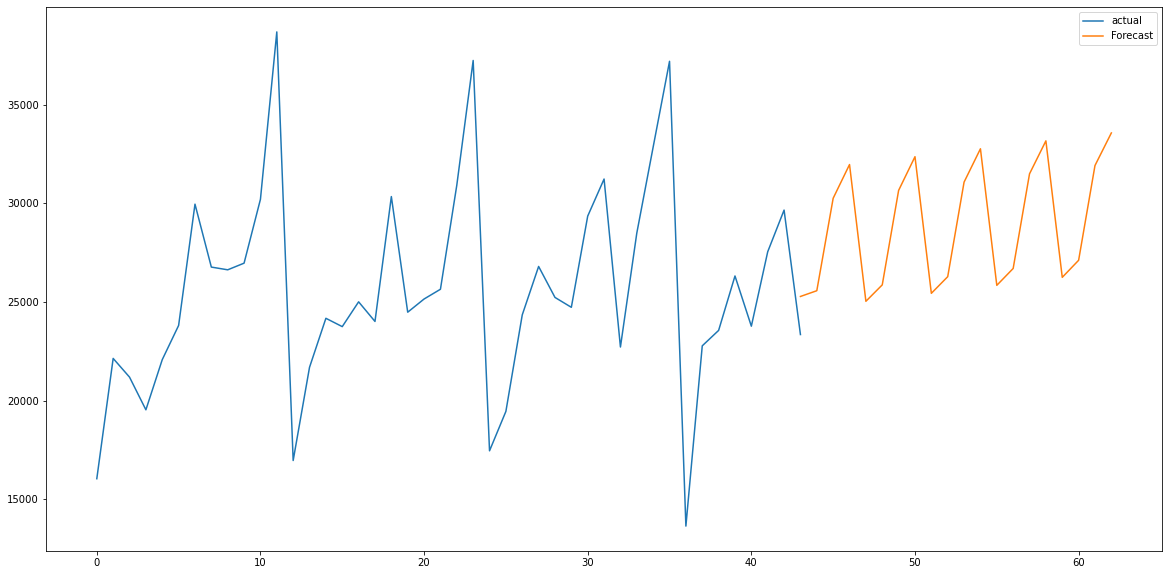

In [21]:
fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = pd.Series(test).index
y = test
# y2 = auto_pred.to_pandas()
plt.plot(x,y,label='actual')
# plt.plot(x,y2,label='predicted')
plt.plot(list(range(max(x), max(x)+20)), cp.asnumpy(z), label = 'Forecast')
ax.legend()

# Holtwinters

In [23]:
# this is a dataset from R
wineind = load_wineind().astype(np.float64)
# training and test sets
train = wineind[:132]
test = wineind[132:]

data = cudf.Series(train)


cu_hw = ExponentialSmoothing(data, seasonal_periods=12)
cu_hw.fit()
cu_pred = cu_hw.forecast(44)

# print('Forecasted points:', cu_pred)
# test[:44]

print(cuml.metrics.regression.mean_squared_error(test, cu_pred, squared = False))

3394.306240066547


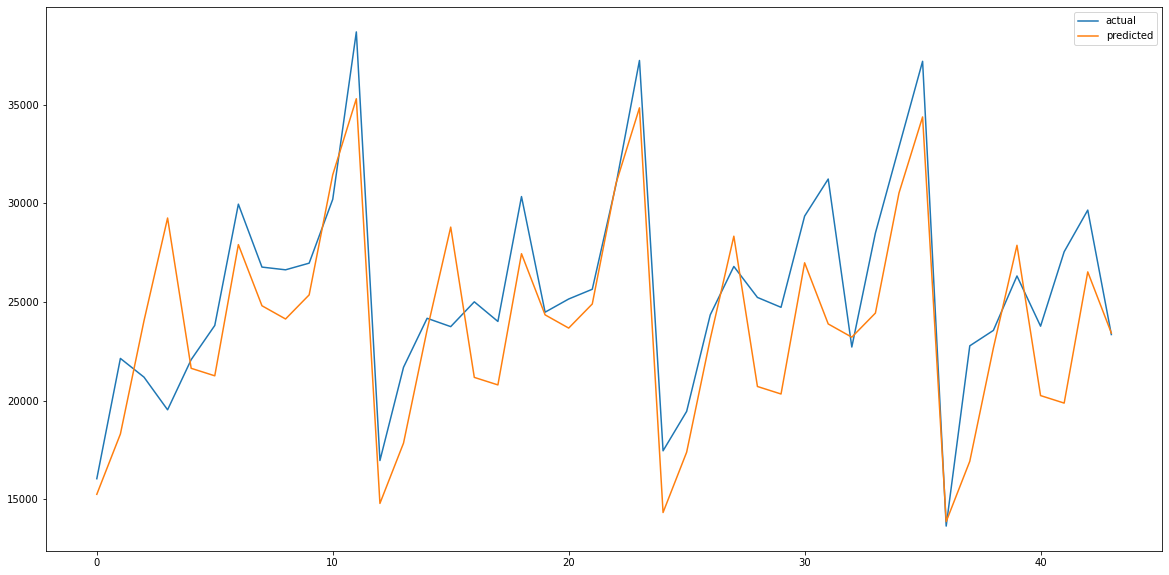

In [24]:
fig, ax = plt.subplots(figsize = (20,10))

# is there a way to not convert to pandas?
x = pd.Series(test).index
y = test
y2 = cu_pred.to_pandas()
plt.plot(x,y,label='actual')
plt.plot(x,y2,label='predicted')
ax.legend()